Check effect of Negative Voja learning rule on MEG response

In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, numpy_bytes_to_str, norm_spa_vecs
from nengo_learn_assoc_mem.paths import data_path

In [3]:
nengo.rc.set("progress", "progress_bar", "nengo.utils.progress.TerminalProgressBar")

## Setup

In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [7]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [8]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [36]:
def weight_eval(rec_weights: np.ndarray, rec_synapse=0.01):
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
    
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengo.Network(seed=seed) as learned_model:
        in_nd = nengo.Node(feed.feed)
        pause = nengo.Node(lambda t: feed.paused)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

        nengo.Connection(in_nd, ens)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
        nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=rec_synapse)

        p_in = nengo.Probe(in_nd)
        p_spikes = nengo.Probe(ens.neurons)

    with nengo.Simulator(learned_model) as learned_sim:
        learned_sim.run(len(feed_vecs)*t_each + t_pause)
        
    return learned_sim.trange(), meg_from_spikes(learned_sim.data[p_spikes])

In [ ]:
def plt_meg(t_range, meg_res):
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[fan1_slc], meg_res[fan1_slc], linestyle=":")
    plt.plot(t_range[fan2_slc], meg_res[fan2_slc], linestyle=":")
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[foil1_slc], meg_res[foil1_slc], linestyle=":")
    plt.plot(t_range[foil2_slc], meg_res[foil2_slc], linestyle=":")
    
    df_list = []

    for key, obj in slc_stim_vecs.items():
        act = meg_res[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    act_df = pd.concat(df_list)
    
    plt.figure()
    ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

    ax.set_title("Difference between FAN1 and FAN2 firing rates")
    ax.set_ylabel("Mean Firing Rate")
    ax.set_xlabel("FAN type")

    ax.legend_.set_title("Target vs. Foil")
    ax.legend_.set_bbox_to_anchor((1, 0.8))
    new_labels = ("Foil", "Target")
    for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)
    
    return act_df

In [37]:
def eval_meg(rec_weights: np.ndarray, rec_synapse=0.01):
    t_range, meg_res = weight_eval(rec_weights, rec_synapse)
    
    plt_meg(t_range, meg_res)

In [38]:
base_inhib_mag = -5e-5

## No Inhib

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:20.                                                                              


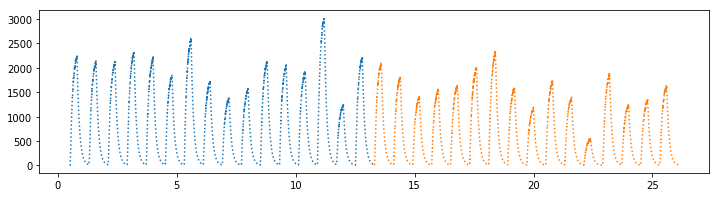

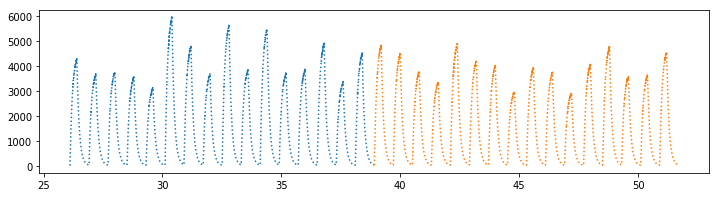

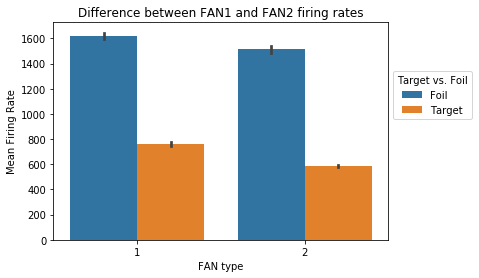

In [39]:
rec_w = np.zeros((n_neurons, n_neurons), dtype=np.float)
no_inhib = eval_meg(rec_w)

## Base case

Everything is inhibited

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:17.                                                                              


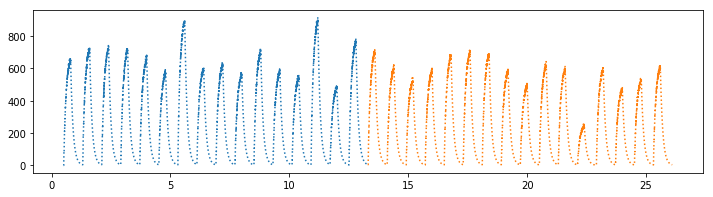

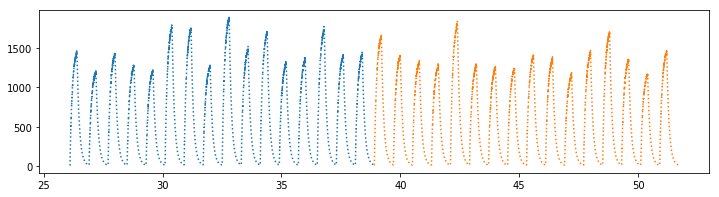

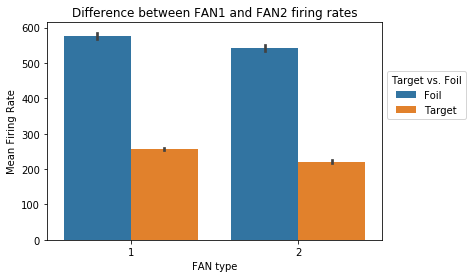

In [40]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
base_inhib = eval_meg(rec_w)

## Selectively weaken inhibition for targets

So the foils don't have such a big MEG response

### Train recurrent connections

In [12]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [13]:
with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

Build finished in 0:00:01.                                                                                   


In [14]:
_, activities = tuning_curves(ens, sim, inputs=np.array(feed_vecs))

In [25]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i], activities[v_i])

In [15]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 1] = 0
np.fill_diagonal(rec_w, 0)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:22.                                                                              


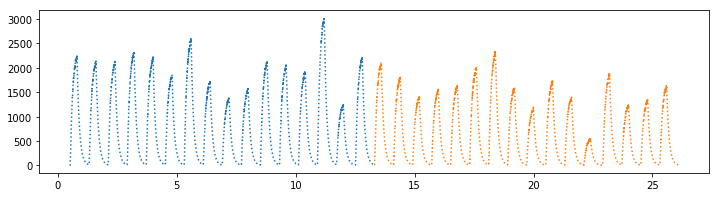

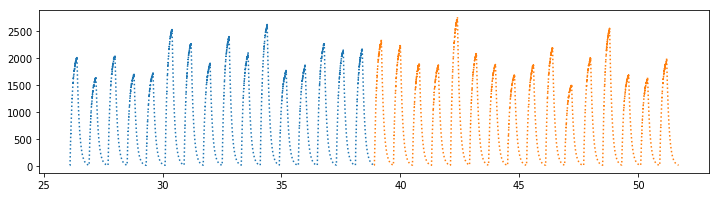

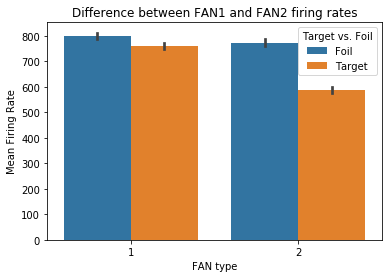

In [16]:
base_comb = eval_meg(rec_w)

## Try more selective inhibition

In [17]:
mean_act = np.mean(activities, axis=0)

(500,)

In [18]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])

In [19]:
np.fill_diagonal(act_corr, 0)

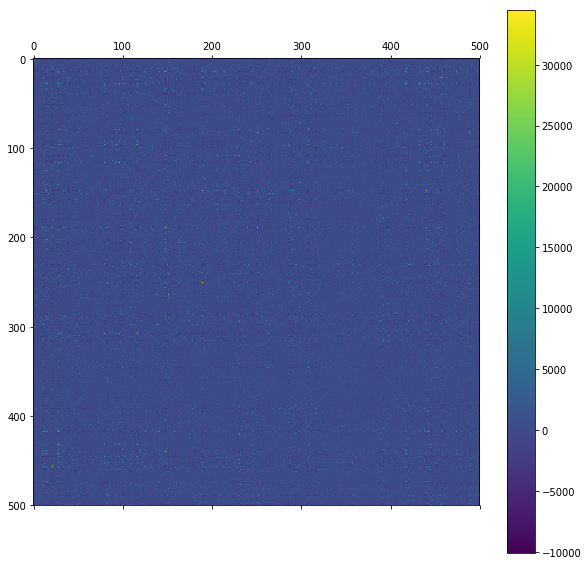

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(act_corr)

fig.colorbar(cax)

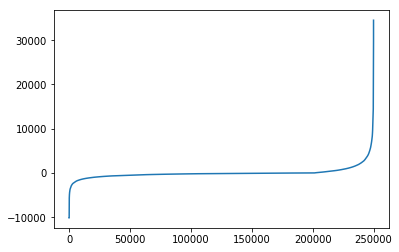

In [21]:
plt.plot(np.sort(act_corr.flatten()))

In [22]:
min_corr = np.min(act_corr)

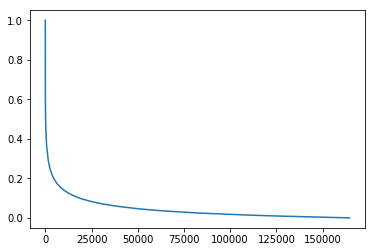

In [23]:
plt.plot(np.sort(act_corr[act_corr < 0]) / min_corr)

In [24]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = 0.
rec_w[act_corr < 0.] = act_corr[act_corr < 0.] / min_corr * -2e-3
np.fill_diagonal(rec_w, 0)

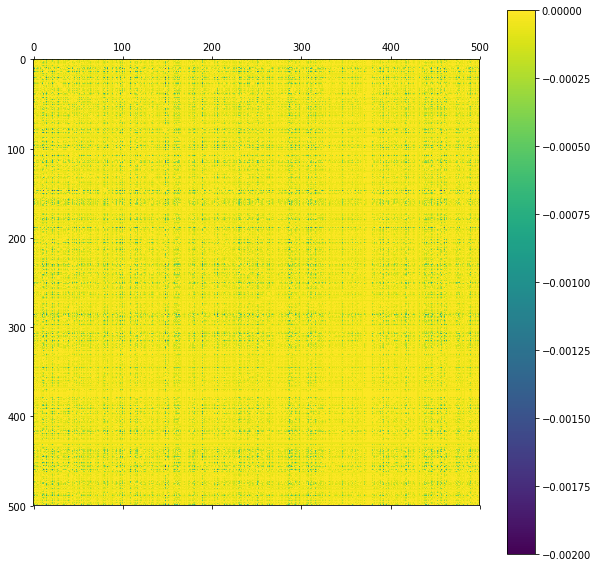

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(rec_w)

fig.colorbar(cax)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:20.                                                                              


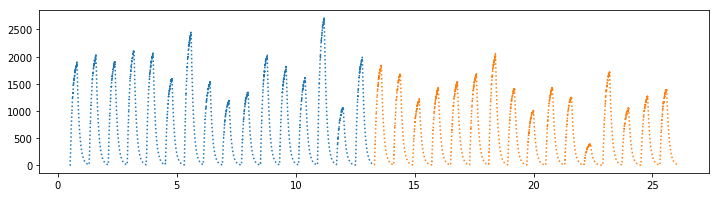

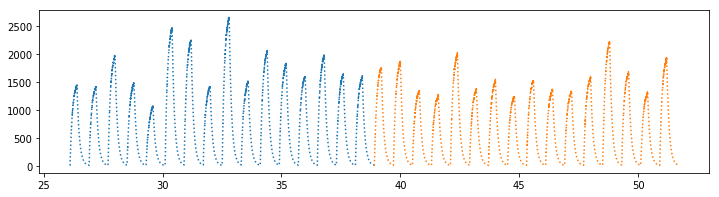

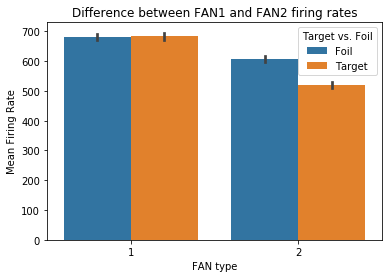

In [26]:
grad_inhib = eval_meg(rec_w)

## Try more selective inhibition removal

In [27]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])

In [28]:
np.fill_diagonal(act_corr, 0)

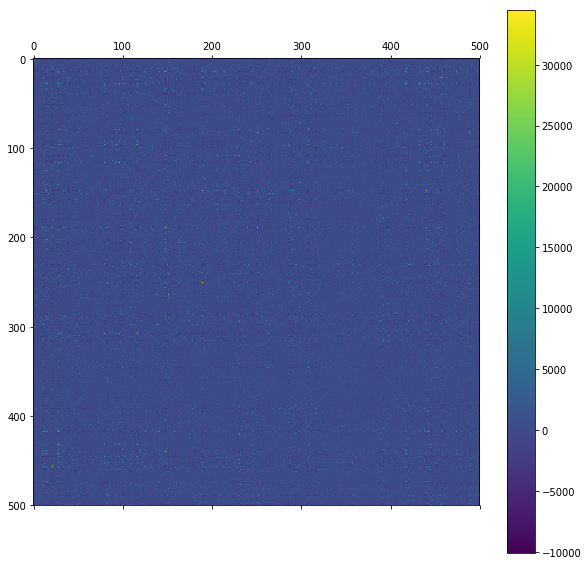

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(act_corr)

fig.colorbar(cax)

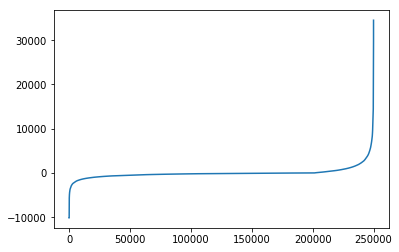

In [30]:
plt.plot(np.sort(act_corr.flatten()))

In [31]:
max_corr = np.max(act_corr)

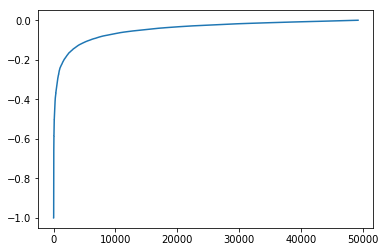

In [32]:
plt.plot(np.sort((1 - act_corr[act_corr > 0]) / max_corr))

In [33]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = (1 - act_corr[act_corr > 0.] / max_corr) * -5e-5
np.fill_diagonal(rec_w, 0)

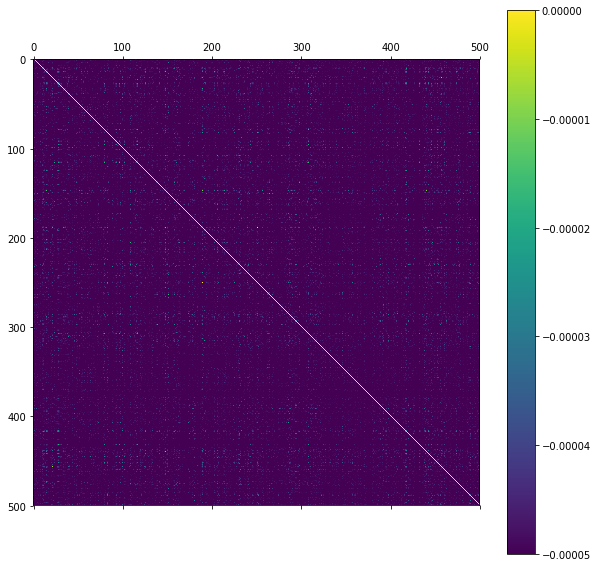

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(rec_w)

fig.colorbar(cax)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:20.                                                                              


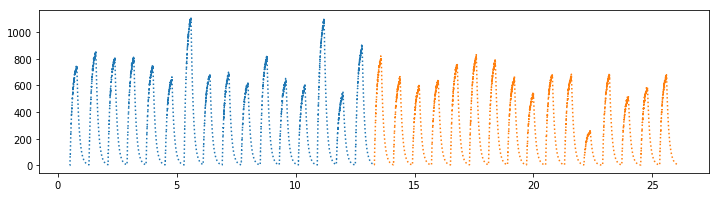

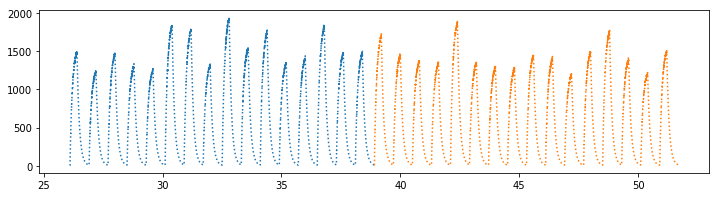

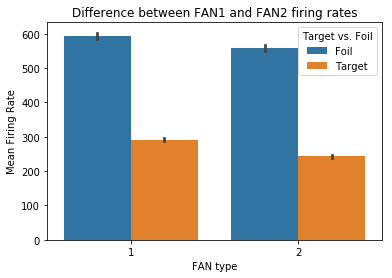

In [35]:
grad_deinhib = eval_meg(rec_w)

## Try both

In [15]:
mean_act = np.mean(activities, axis=0)

In [16]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])

In [17]:
max_corr = np.max(act_corr)
min_corr = np.min(act_corr)

In [18]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag * 10
rec_w[act_corr > 0.] = (1 - act_corr[act_corr > 0.] / max_corr) * -4e-5
rec_w[act_corr < 0.] = act_corr[act_corr < 0.] / min_corr * -6e-1
np.fill_diagonal(rec_w, 0)

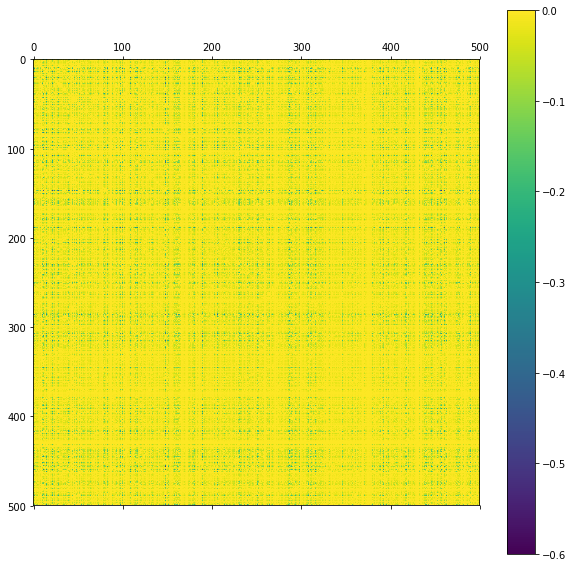

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(rec_w)

fig.colorbar(cax)

### Evaluate recurrent connections on foils

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:18.                                                                              


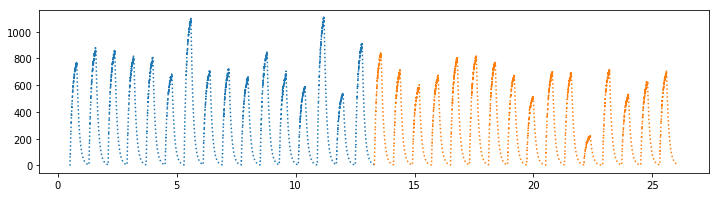

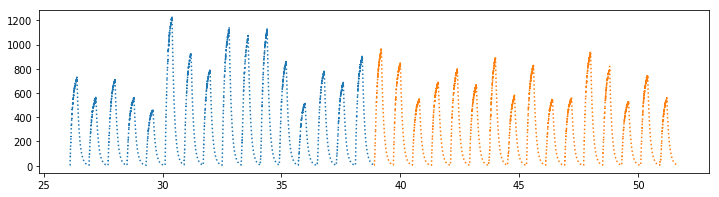

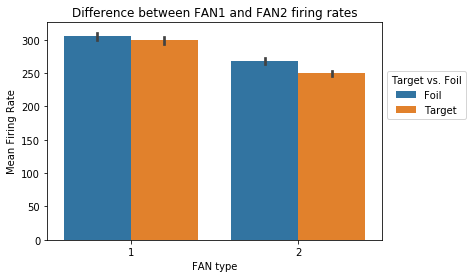

In [33]:
grad_comb = eval_meg(rec_w)

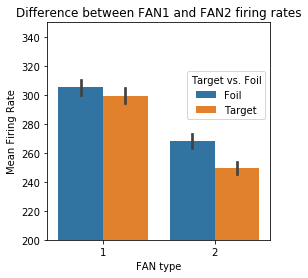

In [34]:
plt.figure(figsize=(4, 4))
ax = sns.barplot(x="resp", y="act", hue="targ", data=grad_comb)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylim((200, 350))
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
ax.legend_.set_bbox_to_anchor((1, 0.8))
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

### Show averaged response over time

In [71]:
grad_meg = weight_eval(rec_w)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:18.                                                                              


In [88]:
fan1_resp = grad_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = grad_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = grad_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = grad_meg[foil2_slc].reshape((-1, td_each))

c:\tools\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0.5,0,'Time (ms)')

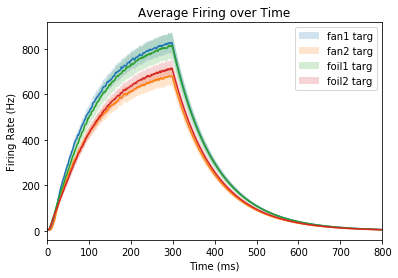

In [92]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

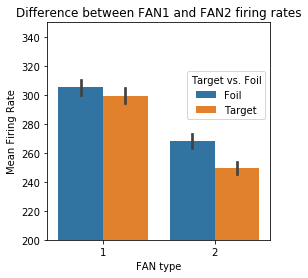

In [34]:
plt.figure(figsize=(4, 4))
ax = sns.barplot(x="resp", y="act", hue="targ", data=grad_comb)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylim((200, 350))
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
ax.legend_.set_bbox_to_anchor((1, 0.8))
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

### Save the resulting weights

In [95]:
with h5py.File(os.path.join(data_path, "bcm_rec_match_weights.h5"), "w") as fi:
    ww = fi.create_dataset("weights", data=rec_w)
    ww.attrs["excite"] = -4e-5
    ww.attrs["inhib"] = -6e-1

## Positive only

In [41]:
mean_act = np.mean(activities, axis=0)

In [42]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])

In [43]:
max_corr = np.max(act_corr)
min_corr = np.min(act_corr)

In [44]:
pos_corr = act_corr[act_corr > 0.]
min_pos_corr = np.min(pos_corr)
neg_corr = act_corr[act_corr < 0.]
max_neg_corr = np.max(neg_corr)

In [45]:
base_inhib_mag

-5e-05

In [46]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = np.interp(pos_corr, (min_pos_corr, max_corr), (base_inhib_mag, 1e-3)) 
#rec_w[act_corr < 0.] = np.interp(neg_corr, (min_corr, max_neg_corr), (base_inhib_mag, -2e-4)) 
np.fill_diagonal(rec_w, 0)

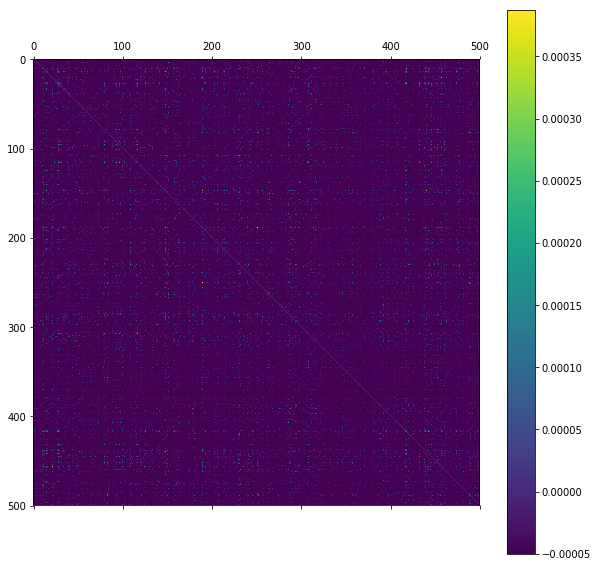

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(rec_w)

fig.colorbar(cax)

### Evaluate recurrent connections on foils

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:18.                                                                              


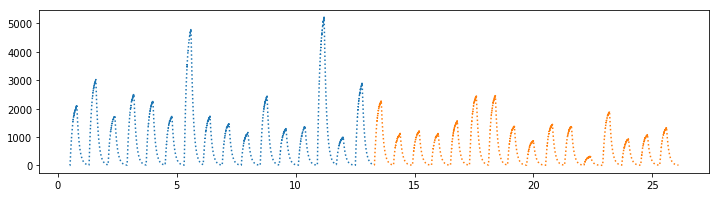

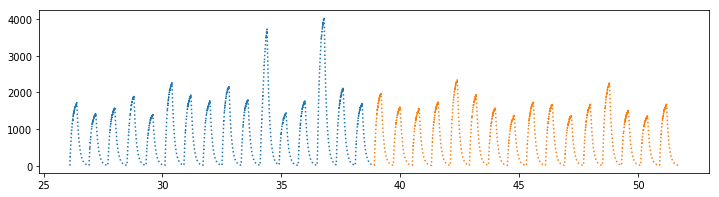

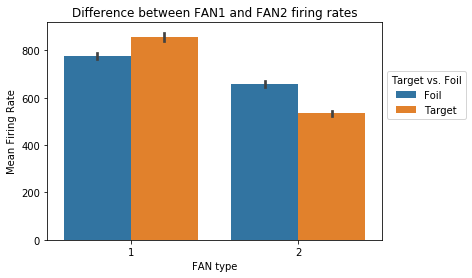

In [48]:
pos_comb = eval_meg(rec_w)

# Positive and Negative combined

In [49]:
mean_act = np.mean(activities, axis=0)

In [50]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for v_i in range(len(feed_vecs)):
    act_corr += np.outer(activities[v_i]-mean_act, activities[v_i])

In [51]:
max_corr = np.max(act_corr)
min_corr = np.min(act_corr)

In [52]:
pos_corr = act_corr[act_corr > 0.]
min_pos_corr = np.min(pos_corr)
neg_corr = act_corr[act_corr < 0.]
max_neg_corr = np.max(neg_corr)

In [53]:
base_inhib_mag

-5e-05

In [117]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = np.interp(pos_corr, (min_pos_corr, max_corr), (base_inhib_mag, 5e-4)) 
rec_w[act_corr < 0.] = np.interp(neg_corr, (min_corr, max_neg_corr), (-7e-3, base_inhib_mag)) 
np.fill_diagonal(rec_w, 0)

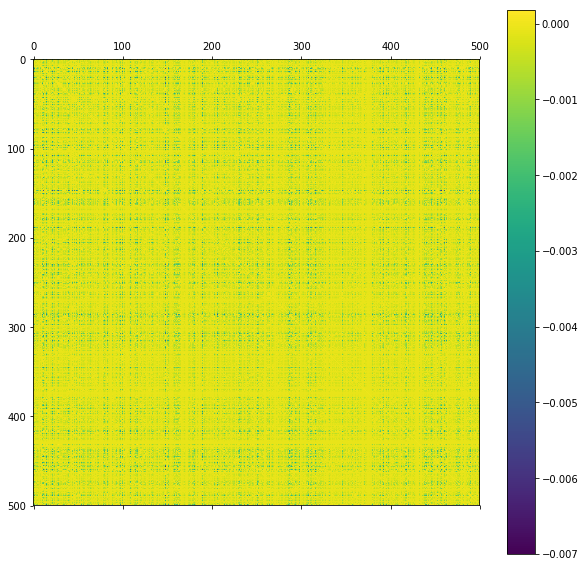

In [118]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(rec_w)

fig.colorbar(cax)

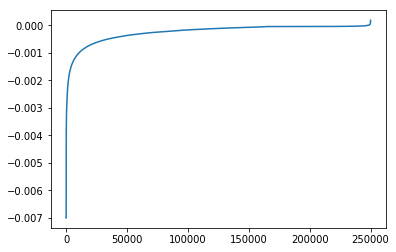

In [119]:
plt.plot(np.sort(rec_w.flatten()))

### Evaluate recurrent connections on foils

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:17.                                                                              


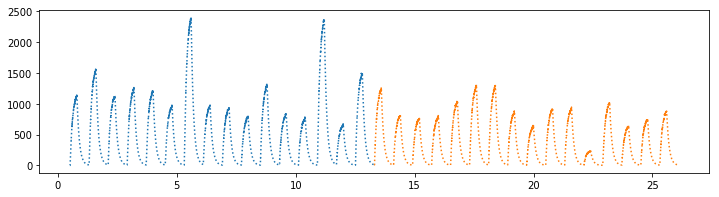

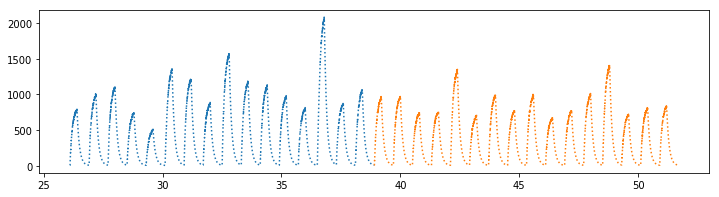

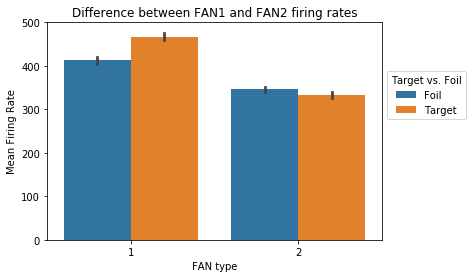

In [120]:
pos_comb = eval_meg(rec_w)

In [121]:
t_range, pos_comb_meg = weight_eval(rec_w)

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:16.                                                                              


In [122]:
fan1_resp = pos_comb_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = pos_comb_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = pos_comb_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = pos_comb_meg[foil2_slc].reshape((-1, td_each))

c:\tools\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


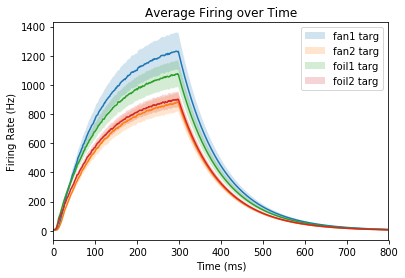

In [123]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

### Save the resulting weights

In [125]:
with h5py.File(os.path.join(data_path, "bcm_rec_pos_match_weights.h5"), "w") as fi:
    ww = fi.create_dataset("weights", data=rec_w)
    ww.attrs["excite"] = 5e-4
    ww.attrs["inhib"] = -7e-3

### Show averaged response over time

In [71]:
grad_meg = weight_eval(rec_w)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:18.                                                                              


In [74]:
grad_meg.shape

(51700,)

In [88]:
fan1_resp = grad_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = grad_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = grad_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = grad_meg[foil2_slc].reshape((-1, td_each))

c:\tools\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0.5,0,'Time (ms)')

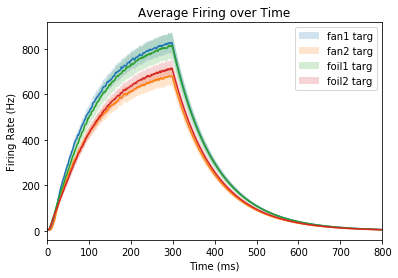

In [92]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

### Save the resulting weights

In [95]:
with h5py.File(os.path.join(data_path, "bcm_rec_match_weights.h5"), "w") as fi:
    ww = fi.create_dataset("weights", data=rec_w)
    ww.attrs["excite"] = -4e-5
    ww.attrs["inhib"] = -6e-1

# Compare
Compare `base_inhib`, `grad_comb`, `base_comb`, `grad_inhib`, `grad_deinhib`

In [40]:
res_dfs = (base_inhib, grad_comb, base_comb, grad_inhib, grad_deinhib)
res_nms = ("base_inhib", "grad_comb", "base_comb", "grad_inhib", "grad_deinhib")

In [41]:
tmp_dfs = []

for df, nm in zip(res_dfs, res_nms):
    print(nm)
    tmp_dfs.append(df.assign(exp=nm))

base_inhib
grad_comb
base_comb
grad_inhib
grad_deinhib


In [42]:
all_res = pd.concat(tmp_dfs, ignore_index=True)

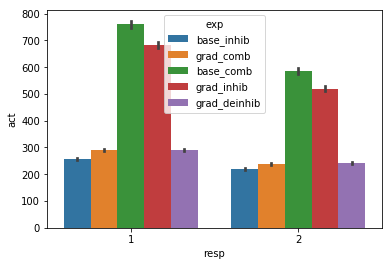

In [43]:
sns.barplot(x="resp", y="act", hue="exp", data=all_res[all_res.targ == True])

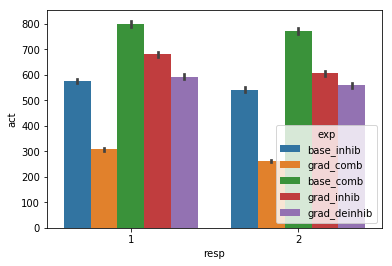

In [44]:
sns.barplot(x="resp", y="act", hue="exp", data=all_res[all_res.targ == False])